# Import Libraries and Define Utility Function

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import os
import datetime as dt
from datetime import datetime, timedelta
from dateutil import parser
import math
import itertools

In [211]:
def create_10min_interval_data(start, end):
    timestamps = []
    current_time = start
    while current_time <= end:
        timestamps.append(current_time)
        current_time += timedelta(minutes=10)
    return timestamps

# Data Preparation

# Load Profile

In [212]:
load_df = pd.read_excel("data/load_raw.xlsx")
load_df.head()

,time,number
0,2022-01-01 00:01:28,33050.3
1,2022-01-01 00:16:28,33051.2
2,2022-01-01 00:31:28,33052.2
3,2022-01-01 00:46:28,33053.0
4,2022-01-01 01:01:28,33053.8


### Aggregate the series into 10min interval data

The original series is roughly in 15-minute intervals. The following code add up groups of 4 interval data and divide it by 6 to get an average profile over an hour in 10-minute intervals.

In [213]:
total_time_steps_2weeks = 2 * 7 * 24 * 4 + 1

load_series = []
for i in range(2 * 7 * 24):
    kWh = sum(load_df.loc[i*4:(i+1)*4].number.values)
    load_series.extend([kWh/6] * 6)

start, end = datetime(2022, 1, 1, 0, 0, 0), datetime(2022, 1, 14, 23, 50, 0)
timestamps = create_10min_interval_data(start, end)

load_cleaned = pd.DataFrame({"timestamps":timestamps, "P_load (kW * 10min)":load_series})
load_cleaned.head()

,timestamps,P_load (kW * 10min)
0,2022-01-01 00:00:00,27543.416667
1,2022-01-01 00:10:00,27543.416667
2,2022-01-01 00:20:00,27543.416667
3,2022-01-01 00:30:00,27543.416667
4,2022-01-01 00:40:00,27543.416667


### Save the data and calculate daily average load

In [214]:
load_cleaned.to_csv("data/load_cleaned.csv", index=False)

In [215]:
load_cleaned["P_load (kW * 10min)"].sum()/6/14

760733.3595238095

# Generate Unit Wind Profile

Formula:
- Input: Wind speed profile, blade length
- Equation: P_avail (kWh) = 1/2 * density of air (kg/m^3) * sweaping area (m^3) * v^3 (m/sec)

Wind speed profile from HK data source: https://data.gov.hk/en-data/dataset/hk-hko-rss-latest-ten-minute-wind-info

In [216]:
directory_path = "data/HK_wind_speed_profile"

files = sorted(os.listdir(directory_path))[1:]

for file in files[:3]:
    print(file)

20220101-0011-latest_10min_wind.csv
20220101-0019-latest_10min_wind.csv
20220101-0029-latest_10min_wind.csv


### Compile files into one single series

In [217]:
total_time_steps_10min = 6 * 2 * 7 * 24

valid_files = files[:total_time_steps_10min]

curr_time = datetime(2022, 1, 1, 0, 0)

timestamps = []
wind_speeds = [] # km/hr

for file in valid_files:
    wind_speed_10min_df = pd.read_csv(f'{directory_path}/{file}')
    wind_speed_10min_HKUST = wind_speed_10min_df[wind_speed_10min_df['Automatic Weather Station'] == 'Sai Kung']
    wind_speed_flt = wind_speed_10min_HKUST['10-Minute Mean Speed(km/hour)'].values[0]
    if math.isnan(wind_speed_flt):
        wind_speed = None # fill in None value if there's no record at the time step
    else: wind_speed = int(wind_speed_flt)
    timestamps.append(curr_time)
    wind_speeds.append(wind_speed)
    curr_time += timedelta(minutes = 10)

wind_speed_df = pd.DataFrame({"timestamp":timestamps, "wind_speed":wind_speeds})

### Dealing with Null data points through Interpolation

In [218]:
wind_speed_df.wind_speed.isnull().sum()

5

In [219]:
none_idx = wind_speed_df.wind_speed[wind_speed_df.wind_speed.isnull()].index
none_idx

Index([133, 219, 316, 867, 882], dtype='int64')

Got the index of None entries, and fill in value by interpolating.

In [220]:
for idx in none_idx:
    wind_speed_df.loc[idx, 'wind_speed'] = (wind_speed_df.loc[idx-1, 'wind_speed'] + wind_speed_df.loc[idx+1, 'wind_speed'])/2

wind_speed_df.loc[none_idx]

,timestamp,wind_speed
133,2022-01-01 22:10:00,1.5
219,2022-01-02 12:30:00,9.0
316,2022-01-03 04:40:00,2.0
867,2022-01-07 00:30:00,23.0
882,2022-01-07 03:00:00,11.5


### Graph time series to see wind speed profile.

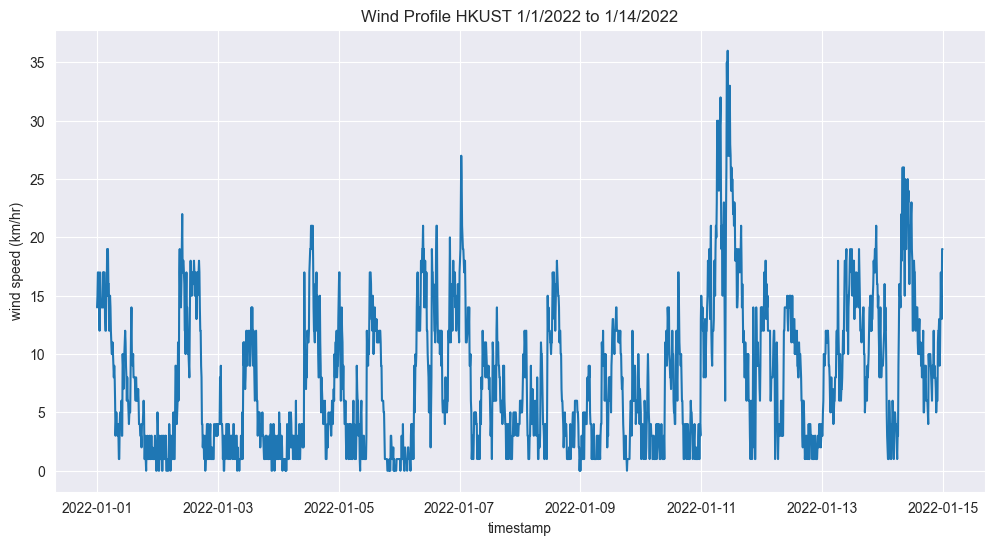

In [221]:
fig = plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
plt.plot(wind_speed_df.timestamp, wind_speed_df.wind_speed)
plt.xlabel("timestamp")
plt.ylabel("wind speed (km/hr)")
plt.title("Wind Profile HKUST 1/1/2022 to 1/14/2022")
plt.show()

Calculate the P_avail for one wind turbine with 32.5 ft blade length, a relatively small turbine for small communities.

In [222]:
radius = 65/2 # ft
air_density = 1.05093 # kg/m3; calculated using average elevation at HK (~1600 ft)
sweaping_area = (radius/3.281)**2 * math.pi # m^3

def convert_to_meter_per_sec(v):
    return v/3.6

def calculate_P_avail_wind(v):
    return 1/2 * air_density * sweaping_area * convert_to_meter_per_sec(v)**3

P_avail = [calculate_P_avail_wind(v) for v in wind_speed_df.wind_speed]
wind_speed_df['P_avail (kW * 10min)'] = P_avail

wind_speed_df.head()

,timestamp,wind_speed,P_avail (kW * 10min)
0,2022-01-01 00:00:00,14.0,9526.306109
1,2022-01-01 00:10:00,15.0,11716.939912
2,2022-01-01 00:20:00,17.0,17056.392826
3,2022-01-01 00:30:00,17.0,17056.392826
4,2022-01-01 00:40:00,14.0,9526.306109


In [223]:
wind_speed_df.to_csv("data/wind_energy_generation.csv", index=False)

Calculate the expected average daily generation by this turbine.

In [224]:
def daily_generation(P_avail_series):
    # divided by 6 to convert kW * 10min to kWh, divided by 14 to get daily average
    return P_avail_series.sum()/6/14

daily_generation(wind_speed_df['P_avail (kW * 10min)'])

135580.58636918748

In [225]:
wind_speed_df.columns

Index(['timestamp', 'wind_speed', 'P_avail (kW * 10min)'], dtype='object')

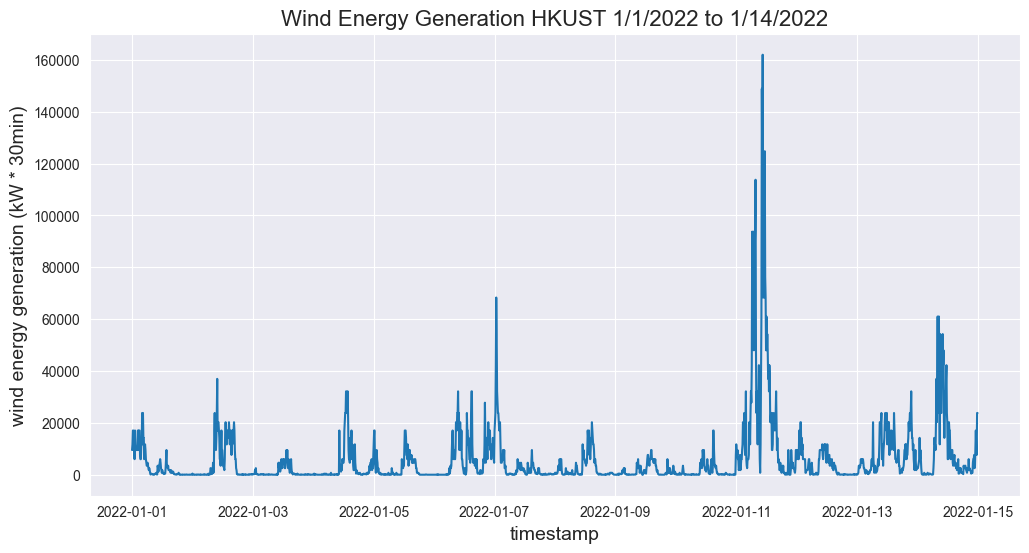

In [226]:
fig = plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
plt.plot(wind_speed_df.timestamp, wind_speed_df['P_avail (kW * 10min)'])
plt.xlabel("timestamp", fontsize=14)
plt.ylabel("wind energy generation (kW * 30min)", fontsize=14)
plt.title("Wind Energy Generation HKUST 1/1/2022 to 1/14/2022", fontsize=16)
plt.show()

# Generate Unit Solar Profile

Formula:
- Input: solar radiation profile, panel area
- Equation: P_avail (kWh) = solar panel area (m^2) * solar radiation (kWh/m^2/hr) * solar panel efficiency (%) * performance ratio (0.75 - 0.9)

Data Source: https://data.gov.hk/en-data/dataset/hk-hko-rss-latest-one-minute-solar-radiation-info

*Here the solar radiation is direct solar radiation

In [227]:
directory_path = "data/HK_solar_radiation_profile"

files = sorted(os.listdir(directory_path))[1:]

for file in files[:3]:
    print(file)

20220101-0011-latest_1min_solar.csv
20220101-0019-latest_1min_solar.csv
20220101-0029-latest_1min_solar.csv


In [228]:
valid_files = files[:total_time_steps_10min]

curr_time = datetime(2022, 1, 1, 0, 0)

timestamps = []
direct_solar_radiation = [] # watt/m^2

for file in valid_files:
    solar_10min_df = pd.read_csv(f'{directory_path}/{file}')
    solar_10min_HKUST = solar_10min_df[solar_10min_df['Automatic Weather Station'] == 'King\'s Park']
    solar_flt = solar_10min_HKUST['Direct Solar Radiation(watt/square meter)'].values[0]
    if math.isnan(solar_flt):
        solar = None # fill in None value if there's no record at the time step
    else: solar = int(solar_flt)*10 # observation of radiation is last 1min. Mutiply by 10 for the sampling rate is once per 10min.
    timestamps.append(curr_time)
    direct_solar_radiation.append(solar)
    curr_time += timedelta(minutes = 10)

solar_df = pd.DataFrame({"timestamp":timestamps, "direct_solar_radiation":direct_solar_radiation})

### Fill in None values through interpolation

In [229]:
solar_df.direct_solar_radiation.isnull().sum()

1

In [230]:
none_idx = solar_df.direct_solar_radiation[solar_df.direct_solar_radiation.isnull()].index
none_idx

Index([994], dtype='int64')

In [231]:
idx = none_idx[0]
solar_df.loc[idx, 'direct_solar_radiation'] = (solar_df.loc[idx-1, 'direct_solar_radiation'] + solar_df.loc[idx+1, 'direct_solar_radiation'])/2

In [232]:
solar_df.loc[idx]

timestamp                 2022-01-07 21:40:00
direct_solar_radiation                    0.0
Name: 994, dtype: object

In [233]:
solar_df.direct_solar_radiation.isnull().sum()

0

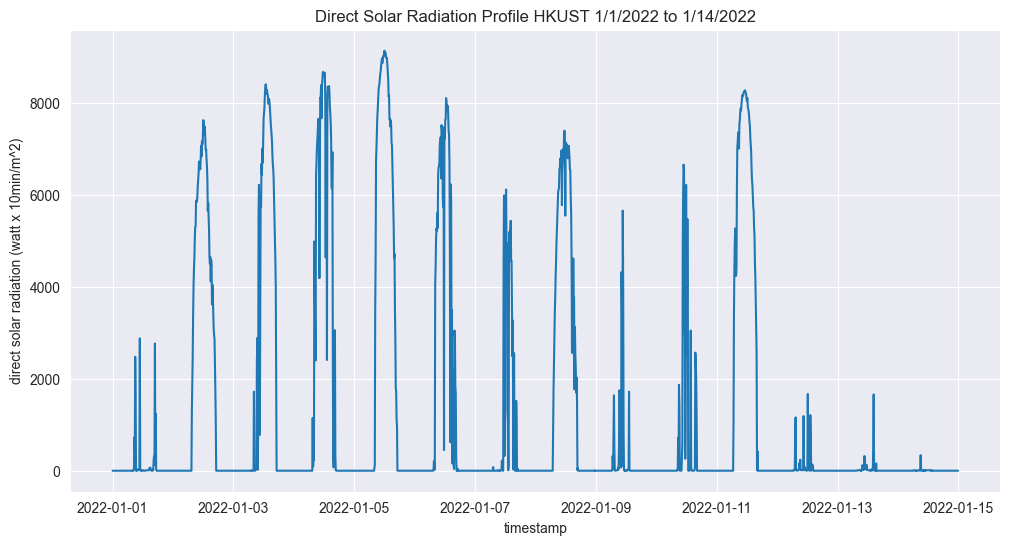

In [234]:
fig = plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
plt.plot(solar_df.timestamp, solar_df.direct_solar_radiation)
plt.xlabel("timestamp")
plt.ylabel("direct solar radiation (watt x 10min/m^2)")
plt.title("Direct Solar Radiation Profile HKUST 1/1/2022 to 1/14/2022")
plt.show()

Here we assume we're installing this particular solar panel: https://shopsolarkits.com/products/rich-solar-mega-550-watt

According to their webpage, the specs of a solar panel is:

- Width x Height: 89.7 x 44.6 in
- Module Efficiency (%): 21.3%

Assuming a performance ratio of 0.85.

As a reminder, P_avail (kWh) = solar panel area (m^2) * solar radiation (kWh/m^2) * solar panel efficiency (%) * performance ratio (0.75 - 0.9)

**Here we calculate watts instead of kW.**

In [235]:
w = 89.7 # inch
h = 44.6 # inch
effi = 0.213
performance_ratio = 0.85

def solar_panel_area(w, h):
    return w * h/39.37**2

def calculate_P_avail_solar(radiation, panel_num=100):
    '''Calculate P_avail for panel_num number of solar panels. panel_num default to 100 panels.'''
    return solar_panel_area(w, h) * effi * performance_ratio * panel_num * radiation

P_avail = [calculate_P_avail_solar(radiation) for radiation in solar_df.direct_solar_radiation]
solar_df['P_avail(watt * 10min)'] = P_avail

solar_panel_area(w, h), solar_df.loc[6*16]

(2.58105032339097,
 timestamp                 2022-01-01 16:00:00
 direct_solar_radiation                   30.0
 P_avail(watt * 10min)             1401.897483
 Name: 96, dtype: object)

Calculate daily generation (in WattsHr)

In [236]:
def daily_generation(P_avail_series):
    '''Calculate average daily solar power generation.
    Sum over 2 weeks of generation profile, divided by 6 to convert W * 10min to Wh, then divided by 14 to get daily average.'''
    return P_avail_series.sum()/6/14

daily_generation(solar_df['P_avail(watt * 10min)'])

1367206.083527098

In [237]:
solar_df.to_csv("data/solar_energy_generation.csv", index=False)

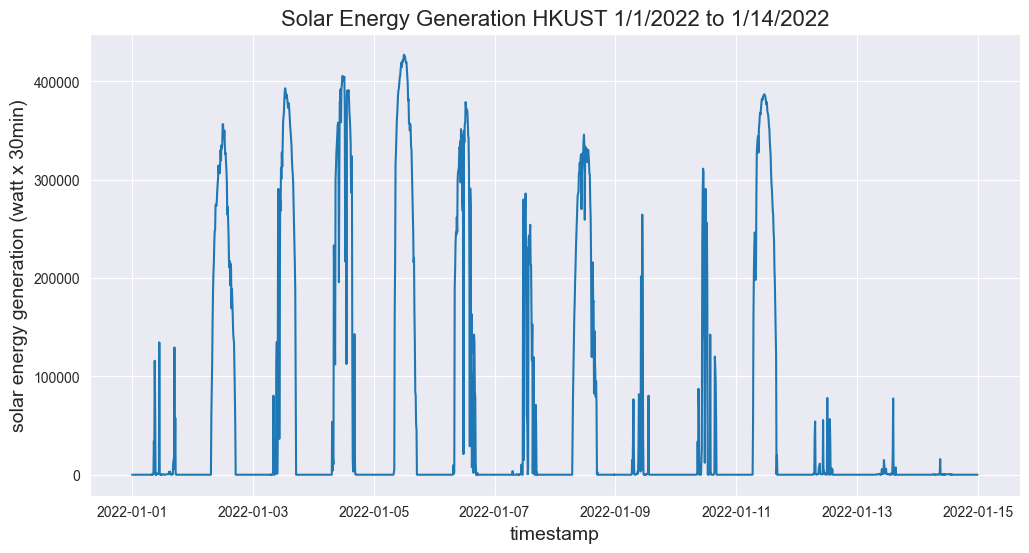

In [238]:
fig = plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

x = solar_df.timestamp.iloc[::3].values
y = solar_df['P_avail(watt * 10min)'].iloc[::3].values

plt.plot(solar_df.timestamp, solar_df['P_avail(watt * 10min)'])
plt.xlabel("timestamp", fontsize=14)
plt.ylabel("solar energy generation (watt x 30min)", fontsize=14)
plt.title("Solar Energy Generation HKUST 1/1/2022 to 1/14/2022", fontsize=16)
plt.show()

# Load and DER Constants and Variables

In [239]:
load_df = pd.read_csv("data/load_cleaned.csv")
load_df.head()

,timestamps,P_load (kW * 10min)
0,2022-01-01 00:00:00,27543.416667
1,2022-01-01 00:10:00,27543.416667
2,2022-01-01 00:20:00,27543.416667
3,2022-01-01 00:30:00,27543.416667
4,2022-01-01 00:40:00,27543.416667


In [240]:
load_df.tail()

,timestamps,P_load (kW * 10min)
2011,2022-01-14 23:10:00,32485.116667
2012,2022-01-14 23:20:00,32485.116667
2013,2022-01-14 23:30:00,32485.116667
2014,2022-01-14 23:40:00,32485.116667
2015,2022-01-14 23:50:00,32485.116667


In [241]:
P_load = list(load_df["P_load (kW * 10min)"].values)

In [242]:
solar_df = pd.read_csv("data/solar_energy_generation.csv")
wind_df = pd.read_csv("data/wind_energy_generation.csv")
solar_df.head()

,timestamp,direct_solar_radiation,P_avail(watt * 10min)
0,2022-01-01 00:00:00,0.0,0.0
1,2022-01-01 00:10:00,0.0,0.0
2,2022-01-01 00:20:00,0.0,0.0
3,2022-01-01 00:30:00,0.0,0.0
4,2022-01-01 00:40:00,0.0,0.0


In [243]:
P_solar = list(solar_df["P_avail(watt * 10min)"].values)
P_solar = [p/1000 for p in P_solar]

In [244]:
wind_df.head()

,timestamp,wind_speed,P_avail (kW * 10min)
0,2022-01-01 00:00:00,14.0,9526.306109
1,2022-01-01 00:10:00,15.0,11716.939912
2,2022-01-01 00:20:00,17.0,17056.392826
3,2022-01-01 00:30:00,17.0,17056.392826
4,2022-01-01 00:40:00,14.0,9526.306109


In [245]:
P_wind = list(wind_df["P_avail (kW * 10min)"].values)

In [246]:
num_intervals = 24 * 14 * 6 # biweekly 10-min intervals
num_intervals

2016

In [247]:
P_grid = cp.Variable(num_intervals)
P_battery_max = cp.Variable()
P_battery = cp.Variable(num_intervals)
P_EV = cp.Variable(num_intervals)
P_battery_charge = cp.Variable(num_intervals)

In [248]:
P_grid.shape

(2016,)

In [249]:
a_P_grid = 1.5 # HK$/kWh
a_P_not_met = 1000 # HK$/kWh (simulating the need for a diesel generator including initial investment and generation cost)
a_wind_turbine = 520000 * 5/8 # HK$ adjusted by per capita GDP ratio
a_solar_panel = 30000 * 5/8
a_battery = 6220 * 5/8
a_energy_curtailed = 0.12 / 0.13 * 5/8 # 0.12 USD / 0.13 (ratio USD to HK$) adjusted by per capita GDP ratio

# General Algorithm

The optimization is formulated as a 2-step problem where battery size and autonomy are optimized first concurrently, and then resilience is optimized based on the battery size obtained.

In [250]:
print(P_load[:5]) # sanity check

[27543.416666666668, 27543.416666666668, 27543.416666666668, 27543.416666666668, 27543.416666666668]


### Solving for Autonomy: Constraints

In [251]:
battery_balance_RHS = P_battery[:num_intervals-1] + P_battery_charge[:num_intervals-1]
battery_constraints = [P_battery[0] == P_battery_max/2, P_battery[1:num_intervals] == battery_balance_RHS, 
                       P_battery <= P_battery_max, P_battery >= 0, P_battery_max >= 0,
                      P_battery_charge <= P_battery_max, -P_battery_max <= P_battery_charge]

c1 = cp.Variable(integer=True)
c2 = cp.Variable(integer=True)
P_energy_curtailed = cp.Variable(num_intervals)
renewable_gen = c1*P_solar[:num_intervals] + c2*P_wind[:num_intervals]
wind_gen = c2*P_wind[:num_intervals]
solar_gen = c1*P_solar[:num_intervals]
renewable_gen = solar_gen + wind_gen
power_gen = renewable_gen + P_grid
power_balance_constraints = [P_load[:num_intervals] + P_battery_charge + P_energy_curtailed - power_gen == 0, 0 <= P_grid,
                            0 <= wind_gen, 0 <= solar_gen, 0 <= power_gen, P_energy_curtailed >= 0, P_energy_curtailed <= renewable_gen]

In [252]:
constraints = itertools.chain(battery_constraints, power_balance_constraints)

# convert a_P_grid to HK$/kWh by dividing it by 6

# Switch between the two objective function to estimate costs and autonomy with or without considering energy curtailments cost. 
# obj_fc = cp.Minimize(a_battery*P_battery_max + a_solar_panel * c1 * 12/100 + a_wind_turbine * c2 + a_P_grid*cp.sum(P_grid)/6 + a_energy_curtailed * cp.sum(P_energy_curtailed)/6)
obj_fc = cp.Minimize(a_battery*P_battery_max + a_solar_panel * c1 * 12/100 + a_wind_turbine * c2 + a_P_grid*cp.sum(P_grid)/6)
problem = cp.Problem(obj_fc, constraints)
problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Dec 13 02:56:14 AM: Your problem has 8067 variables, 24193 constraints, and 0 parameters.
(CVXPY) Dec 13 02:56:14 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 13 02:56:14 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 13 02:56:14 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 13 02:56:14 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 13 02:56:14 AM: Compiling problem (target solver=SCIP)

10582243.648011215

In [253]:
import math
import statistics

battery = a_battery*P_battery_max * 0.13
solar = a_solar_panel * c1.value * 12/100 * 0.13
wind = a_wind_turbine * c2.value * 0.13
grid = a_P_grid*sum(P_grid.value)/6 * 0.13
curtailed = a_energy_curtailed * sum(P_energy_curtailed.value)/6 * 0.13
total = problem.value*0.13

print(f"Result break down (excluding minimizing curtailment): \n\n{round(total/1000/1000, 2)} million USD including setup costs with expectation of on average {round(sum(P_load)/6/14,2)} kWh daily load, equivalent to {round(sum(P_load)/6/14/1000,2)} MGhr (including solar/wind installation & purchase costs and curtailed power cost)")
print(f"Average Power from grid: {round(sum(P_grid.value)/6/14, 2)} kWh (= {round(sum(P_grid.value)/6/14/1000, 2)} MWhr)")
print(f"Average Renewable Energy Generation: {round(sum(renewable_gen.value)/6/14,2)} kWh (= {round(sum(renewable_gen.value)/6/14/1000,2)} MWhr)")
print(f"Number of small solar panels: {round(float(c1.value))}, costs: {round(solar, 2)} USD (= {round(solar/1000, 2)}k USD)")
print(f"Number of wind turbine with 32.5ft blade length: {c2.value}, costs: {round(wind, 2)} USD (= {round(wind/1000, 2)} k USD)")
print(f"Battery storage size: {round(float(P_battery_max.value))}")

renewable_percentage = round((sum(renewable_gen.value) - sum(P_energy_curtailed.value))/sum(P_load)*100, 2)
print(f"\n{renewable_percentage} % of total energy used is generated using solar and wind. (Curtailed energy was subtracted)\n")

P_load_cost = a_P_grid*sum(P_load)*0.13/6
print(f"Two week P_grid costs: {round(grid, 2)} USD (= {round(grid/1000/1000, 2)} million USD)")
print(f"Two week P_grid without renewable costs: {round(P_load_cost/1000/1000, 2)} million USD, microgrid reduced cost by {round(1 - grid/P_load_cost, 4)*100} %, overall reduced cost by {round(100 - total/P_load_cost*100, 2)} % (taking into account solar and wind installation & purchase, and cost of energy curtailed)\n")

print(f"Average Power curtailed: {round(statistics.mean(P_energy_curtailed.value)*6, 2)} kWh (= {round(statistics.mean(P_energy_curtailed.value)*6/1000, 2)} MWhr)")
print(f"Two week P_energy_curtailed costs: {round(curtailed, 2)} USD (= {round(curtailed/1000/1000, 2)} million USD)\n")

Result break down (excluding minimizing curtailment): 

1.38 million USD including setup costs with expectation of on average 760733.36 kWh daily load, equivalent to 760.73 MGhr (including solar/wind installation & purchase costs and curtailed power cost)
Average Power from grid: 413785.41 kWh (= 413.79 MWhr)
Average Renewable Energy Generation: 840600.46 kWh (= 840.6 MWhr)
Number of small solar panels: 119, costs: 34807.5 USD (= 34.81k USD)
Number of wind turbine with 32.5ft blade length: 5.0, costs: 211250.0 USD (= 211.25 k USD)
Battery storage size: 0

45.61 % of total energy used is generated using solar and wind. (Curtailed energy was subtracted)

Two week P_grid costs: 1129634.17 USD (= 1.13 million USD)
Two week P_grid without renewable costs: 2.08 million USD, microgrid reduced cost by 45.61 %, overall reduced cost by 33.76 % (taking into account solar and wind installation & purchase, and cost of energy curtailed)

Average Power curtailed: 123413.13 kWh (= 123.41 MWhr)
Two wee

In [254]:
P_battery_max.value

array(0.)

### Solving Resilience (P_notmet)

In [255]:
c1.value, c2.value

(array(119.), array(5.))

In [261]:
total_i = 12 * 7 # 7 days every 2 hours

hours_interval = 2 * 6 # number of 10 minute intervals in 2 hours
interval_start_idx = 0
num_intervals_ahead = 7 * 24 * 6 # 7 days ahead in 10 minute interval

# Maximizing resiliency for island mode trails in increments of 2 hours for 7 days
# Record the total lasting hours = resiliency for every trial and starting timestamps
total_lasting_hours = []
timestamps = []
for i in list(range(total_i)):
    if i == 0: timestamps.append(datetime(2022, 1, 1, 0, 0, 0))
    else: timestamps.append(timestamps[-1] + timedelta(minutes=hours_interval*10))
    interval_start = i * hours_interval
    interval_end = interval_start + num_intervals_ahead
    P_battery_max_resi = 50000
    P_battery_resi = cp.Variable(num_intervals_ahead)
    P_battery_charge_resi = cp.Variable(num_intervals_ahead)
    battery_balance_RHS_resi = P_battery_resi[:num_intervals_ahead-1] + P_battery_charge_resi[:num_intervals_ahead-1]
    battery_constraints_resi = [P_battery_resi[0] == P_battery_max_resi, 
                                P_battery_resi[1:num_intervals_ahead] == battery_balance_RHS_resi, 
                                P_battery_resi <= P_battery_max_resi, P_battery_resi >= 0]

    c1_resi = c1.value
    c2_resi = c2.value
    P_notmet = cp.Variable(num_intervals_ahead)
    P_energy_curtailed_resi = cp.Variable(num_intervals_ahead)
    renewable_gen_resi = [s*c1_resi + w*c2_resi for s, w in zip(P_solar[interval_start:interval_end], P_wind[interval_start:interval_end])]
    power_balance_constraints_resi = [P_load[interval_start:interval_end] - P_notmet + P_battery_charge_resi - renewable_gen_resi + P_energy_curtailed_resi == 0, 
                                      0 <= P_notmet, P_notmet <= P_load[interval_start:interval_end],
                                     P_energy_curtailed_resi >= 0, P_energy_curtailed_resi <= renewable_gen_resi]
    
    constraints_resilience = itertools.chain(battery_constraints_resi, power_balance_constraints_resi)
    
    obj_fc_setup = a_battery * P_battery_max_resi + a_solar_panel * c1_resi * 5/100 + a_wind_turbine * c2_resi
    obj_fc_resilience = cp.Minimize(obj_fc_setup + a_P_not_met*cp.sum(P_notmet)/6)
    problem_resilience = cp.Problem(obj_fc_resilience, constraints_resilience)
    problem_resilience.solve()
    
    critical_load_p = 0.15 # critical load percentgae

    # Calculate the load not met percentage for the 7 days ahead. 
    # If at a timestep t, the load not met percentage goes over 1 - critical load percentage,
    # Then the critical loads are not met, and the microgrid fails to function at time t
    # And t/6 would be the duration where the microgrid survivied island mode = the resiliency at starting timestep
    load_percentage = np.array([round(p_notmet/p_load*100, 2) for p_notmet, p_load in zip(P_notmet.value, P_load[interval_start:interval_end])])
    indices = np.where(load_percentage/100 > 1 - critical_load_p)[0]
    if len(indices) == 0: indices = [num_intervals_ahead-1]
    print(f"Lasted: {(indices[0]+1)/6} hrs. Starting time: {timestamps[-1]}")
    total_lasting_hours.append(indices[0]/6)

Lasted: 7.5 hrs. Starting time: 2022-01-01 00:00:00
Lasted: 5.5 hrs. Starting time: 2022-01-01 02:00:00
Lasted: 3.5 hrs. Starting time: 2022-01-01 04:00:00
Lasted: 1.5 hrs. Starting time: 2022-01-01 06:00:00
Lasted: 9.0 hrs. Starting time: 2022-01-01 08:00:00
Lasted: 7.0 hrs. Starting time: 2022-01-01 10:00:00
Lasted: 5.0 hrs. Starting time: 2022-01-01 12:00:00
Lasted: 3.0 hrs. Starting time: 2022-01-01 14:00:00
Lasted: 1.1666666666666667 hrs. Starting time: 2022-01-01 16:00:00
Lasted: 0.3333333333333333 hrs. Starting time: 2022-01-01 18:00:00
Lasted: 0.16666666666666666 hrs. Starting time: 2022-01-01 20:00:00
Lasted: 0.3333333333333333 hrs. Starting time: 2022-01-01 22:00:00
Lasted: 0.3333333333333333 hrs. Starting time: 2022-01-02 00:00:00
Lasted: 0.3333333333333333 hrs. Starting time: 2022-01-02 02:00:00
Lasted: 0.3333333333333333 hrs. Starting time: 2022-01-02 04:00:00
Lasted: 0.6666666666666666 hrs. Starting time: 2022-01-02 06:00:00
Lasted: 9.833333333333334 hrs. Starting time: 2

# Visualizing Resiliency Profile and Histogram

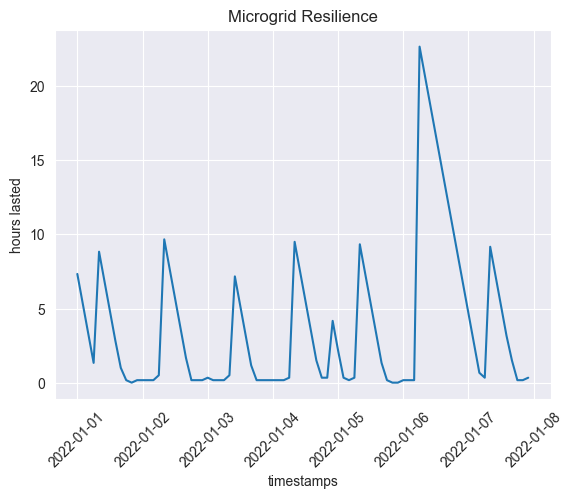

In [257]:
plt.plot(timestamps, total_lasting_hours)
plt.xlabel('timestamps')
plt.ylabel('hours lasted')
plt.title('Microgrid Resilience')
plt.xticks(rotation=45)
plt.show()

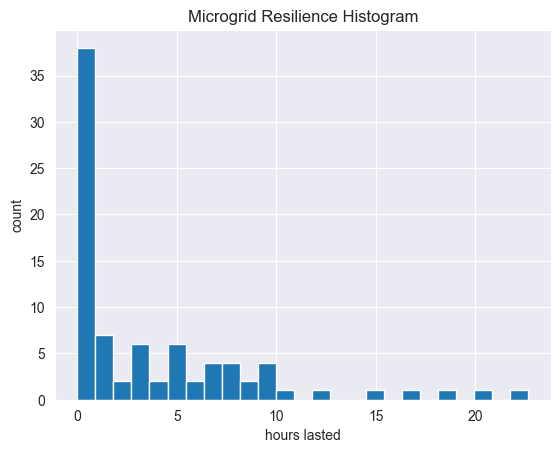

In [258]:
plt.hist(total_lasting_hours, bins=25)
plt.xlabel('hours lasted')
plt.ylabel('count')
plt.title('Microgrid Resilience Histogram')
plt.show()

### Average, median and maximum Resiliency

In [259]:
np.array(total_lasting_hours).mean(), statistics.median(total_lasting_hours) , max(total_lasting_hours)

(3.8214285714285716, 1.4166666666666665, 22.666666666666668)

### Average Resiliency at daylight

In [260]:
hrs = pd.Series(total_lasting_hours)
hrs[hrs>1].mean()

6.925925925925927